In [1]:
import sys
import os
import csv
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from copy import deepcopy

#modeling
from sklearn.feature_selection import chi2, f_regression, VarianceThreshold
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier, LGBMRegressor

#metrics
from sklearn.metrics import roc_auc_score, accuracy_score

sns.set_style('darkgrid')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

SEED = 26
np.random.seed(SEED)

In [2]:
def utility_score(df_eval, action_col='pred'):
    
    i_size = df_eval['date'].nunique()
    df_eval['score'] = df_eval['weight']*df_eval['resp']*df_eval[action_col]
    
    pi = df_eval.groupby('date').sum()['score'].values
    pi_squared = np.power(pi,2)
    
    t = (np.sum(pi)/np.sqrt(np.sum(pi_squared)))*np.sqrt((250/i_size))
    u = min(max(t,0),6)*np.sum(pi)
    
    return u

### Read in Feature Engineered Datasets

In [3]:
%%time
dtype_dict = {}
for f in range(0,130):
    dtype_dict[f'feature_{f}'] = 'float32'
df = pd.read_csv('../inputs/train.csv')
#df = pd.read_csv('../preprocessed/simple_features.csv')

CPU times: user 1min 8s, sys: 22.7 s, total: 1min 31s
Wall time: 2min 14s


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float64(135), int64(3)
memory usage: 2.5 GB


In [5]:
df['feature_0'] = df['feature_0'].replace(-1,0)

### Read in Folds

In [6]:
%%time
train_fold_ind = pd.read_csv('../preprocessed/train_fold_ind.csv')

CPU times: user 553 ms, sys: 10.1 ms, total: 563 ms
Wall time: 1 s


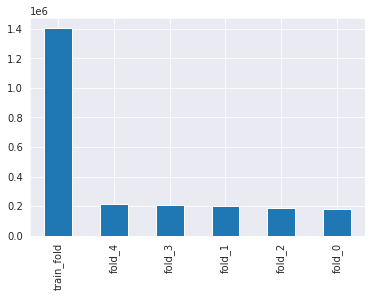

In [7]:
train_fold_ind['fold'].value_counts().plot(kind='bar');

In [8]:
df = pd.concat([df,train_fold_ind[['fold']]],axis=1)

### Build Target

In [9]:
# simple binary target, if resp > 0 
df['target'] = df['resp'].apply(lambda x: 1 if x > 0 else 0)
#df['target'] = df['resp'] # for regression

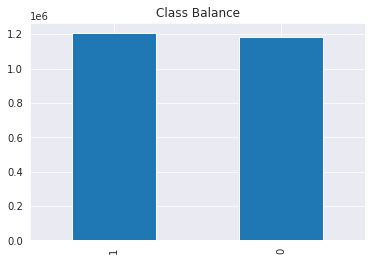

In [10]:
df['target'].value_counts().plot(kind='bar')
plt.title("Class Balance");

### Drop and Index Non-Feature Columns

In [11]:
df = df.drop(['resp_1','resp_2','resp_3','resp_4'], axis=1)
df = df.set_index(['date','ts_id','weight','resp'])

### Impute Missing

In [12]:
# fill with 0 as all features scaled...therefore mean is 0
df = df.fillna(value=0, axis=1)

### Feature Selection

In [13]:
all_features = [col for col in df.columns if col not in ['fold','target']]
drop_cols = []

In [14]:
df.head()

feature_0  feature_1  feature_2  feature_3  \
date ts_id weight resp                                                 
0    0     0.000  0.006           1     -1.873     -2.191     -0.474   
     1     16.674 -0.010          0     -1.350     -1.705      0.068   
     2     0.000  0.024           0      0.813     -0.256      0.806   
     3     0.000  -0.003          0      1.174      0.345      0.067   
     4     0.139  -0.003          1     -3.172     -3.093     -0.162   

                          feature_4  feature_5  feature_6  feature_7  \
date ts_id weight resp                                                 
0    0     0.000  0.006      -0.323      0.015     -0.002      0.000   
     1     16.674 -0.010      0.028      0.194      0.138      0.000   
     2     0.000  0.024       0.400     -0.614     -0.355      0.000   
     3     0.000  -0.003      0.009     -1.006     -0.676      0.000   
     4     0.139  -0.003     -0.128     -0.195     -0.144      0.000   

                          feature_8  feature_9  ...  feature_122  feature_123  \
date ts_id weight resp                          ...                             
0    0     0.000  0.006       0.000     -0.990  ...        1.168        8.314   
     1     16.674 -0.010      0.000     -0.152  ...       -1.179        1.777   
     2     0.000  0.024       0.000      5.448  ...        6.116        9.668   
     3     0.000  -0.003      0.000      4.508  ...        2.839        0.499   
     4     0.139  -0.003      0.000      2.683  ...        0.345        4.101   

                          feature_124  feature_125  feature_126  feature_127  \
date ts_id weight resp                                                         
0    0     0.000  0.006         1.782       14.018        2.653       12.600   
     1     16.674 -0.010       -0.915        2.832       -1.417        2.297   
     2     0.000  0.024         5.543       11.672        7.282       10.060   
     3     0.000  -0.003        3.034        1.513        4.398        1.266   
     4     0.139  -0.003        0.614        6.623        0.800        5.233   

                          feature_128  feature_129        fold  target  
date ts_id weight resp                                                  
0    0     0.000  0.006         2.301       11.446  train_fold       1  
     1     16.674 -0.010       -1.305        1.899  train_fold       0  
     2     0.000  0.024         6.638        9.427  train_fold       1  
     3     0.000  -0.003        3.856        1.013  train_fold       0  
     4     0.139  -0.003        0.363        3.927  train_fold       0  

[5 rows x 132 columns]

In [15]:
%%time
f_reg_results = f_regression(X=df[df['fold']=='train_fold'][all_features].values,
                             y=df[df['fold']=='train_fold']['target'].values)

CPU times: user 2.4 s, sys: 5.82 s, total: 8.22 s
Wall time: 8.05 s


In [16]:
f_reg_results = pd.DataFrame(list(zip(all_features,f_reg_results[1])),columns=['feature','p_value']).sort_values(by='p_value',ascending=True)

In [17]:
f_reg_results[f_reg_results['p_value']>0.05]

,feature,p_value
111,feature_111,0.101
96,feature_96,0.107
127,feature_127,0.148
121,feature_121,0.177
108,feature_108,0.211
4,feature_4,0.306
98,feature_98,0.377
5,feature_5,0.471
93,feature_93,0.485
78,feature_78,0.579


In [18]:
df.head()

feature_0  feature_1  feature_2  feature_3  \
date ts_id weight resp                                                 
0    0     0.000  0.006           1     -1.873     -2.191     -0.474   
     1     16.674 -0.010          0     -1.350     -1.705      0.068   
     2     0.000  0.024           0      0.813     -0.256      0.806   
     3     0.000  -0.003          0      1.174      0.345      0.067   
     4     0.139  -0.003          1     -3.172     -3.093     -0.162   

                          feature_4  feature_5  feature_6  feature_7  \
date ts_id weight resp                                                 
0    0     0.000  0.006      -0.323      0.015     -0.002      0.000   
     1     16.674 -0.010      0.028      0.194      0.138      0.000   
     2     0.000  0.024       0.400     -0.614     -0.355      0.000   
     3     0.000  -0.003      0.009     -1.006     -0.676      0.000   
     4     0.139  -0.003     -0.128     -0.195     -0.144      0.000   

                          feature_8  feature_9  ...  feature_122  feature_123  \
date ts_id weight resp                          ...                             
0    0     0.000  0.006       0.000     -0.990  ...        1.168        8.314   
     1     16.674 -0.010      0.000     -0.152  ...       -1.179        1.777   
     2     0.000  0.024       0.000      5.448  ...        6.116        9.668   
     3     0.000  -0.003      0.000      4.508  ...        2.839        0.499   
     4     0.139  -0.003      0.000      2.683  ...        0.345        4.101   

                          feature_124  feature_125  feature_126  feature_127  \
date ts_id weight resp                                                         
0    0     0.000  0.006         1.782       14.018        2.653       12.600   
     1     16.674 -0.010       -0.915        2.832       -1.417        2.297   
     2     0.000  0.024         5.543       11.672        7.282       10.060   
     3     0.000  -0.003        3.034        1.513        4.398        1.266   
     4     0.139  -0.003        0.614        6.623        0.800        5.233   

                          feature_128  feature_129        fold  target  
date ts_id weight resp                                                  
0    0     0.000  0.006         2.301       11.446  train_fold       1  
     1     16.674 -0.010       -1.305        1.899  train_fold       0  
     2     0.000  0.024         6.638        9.427  train_fold       1  
     3     0.000  -0.003        3.856        1.013  train_fold       0  
     4     0.139  -0.003        0.363        3.927  train_fold       0  

[5 rows x 132 columns]

## Models

In [41]:
def run_models(estimator):
    
    results = {}
    df_test_results = pd.DataFrame()
    
    results['estimator'] = {}
    results['train_auc'] = {}
    results['train_acc'] = {}
    results['test_auc'] = {}
    results['test_acc'] = {}
    results['utility_score'] = {}
        
    lr_model = deepcopy(estimator)
    
    train_fold_list = ['train_fold']

    for fold in tqdm(range(0, df['fold'].nunique()-1, 1)):

        # split fold
        train_fold_list.append(f'fold_{fold}')
        
        df_train = df[df['fold'].isin(train_fold_list[0:-1])]
        df_test = df[df['fold'].isin([train_fold_list[-1]])]
        
        df_train = df_train.drop('fold', axis=1)
        df_test = df_test.drop('fold', axis=1)

        # make X,y
        X_train = df_train.drop('target', axis=1)
        y_train = df_train['target'].values
        X_test = df_test.drop('target', axis=1)
        y_test = df_test['target'].values

        print(f"Fitting Fold {train_fold_list[0:-1]} Model ({X_train.shape[0]} samples) ...")
        lr_model.fit(X_train,y_train)

        # make predictions
        train_pred_prob = lr_model.predict_proba(X_train)[:,1]
        train_pred = np.where(train_pred_prob>0.5,1,0)

        test_pred_prob = lr_model.predict_proba(X_test)[:,1]
        test_pred = np.where(test_pred_prob>0.5,1,0)
        
        print("Example Probs: ", test_pred_prob[0:5])

        print("Complete.\n")

        # calculate scores
        train_auc = roc_auc_score(y_train, train_pred_prob)
        train_acc = accuracy_score(y_train, train_pred)

        test_auc = roc_auc_score(y_test, test_pred_prob)
        test_acc = accuracy_score(y_test, test_pred)

        print(f"Fold {train_fold_list[0:-1]} Train Scores: ")
        print(f"AUC: {train_auc}")
        print(f"Accuracy: {train_acc}")
        print("\n")

        print(f"Fold {train_fold_list[-1]} Test Scores: ")
        print(f"AUC: {test_auc}")
        print(f"Accuracy: {test_acc}")
        
        
        # save fold results
        results_df = df_test.reset_index()[['date','weight','resp']].copy()
        results_df['fold'] = train_fold_list[-1]
        results_df['actual'] = y_test
        results_df['pred_prob'] = test_pred_prob
        results_df['pred'] = test_pred
        df_test_results = df_test_results.append(results_df)
        
        u = utility_score(results_df, action_col='pred')
        u_ideal = utility_score(results_df, action_col='actual')
        print("Utility Score: ", u)
        print("Utility Score Ideal: ", u_ideal)
        print("\n")
        
        results['estimator'][train_fold_list[-1]] = lr_model
        results['train_auc'][train_fold_list[-1]] = train_auc
        results['train_acc'][train_fold_list[-1]] = train_acc
        results['test_auc'][train_fold_list[-1]] = test_auc
        results['test_acc'][train_fold_list[-1]] = test_acc    
        results['utility_score'][train_fold_list[-1]] = u
        
    return results, df_test_results

In [23]:
%%time
estimator = LogisticRegression(solver='sag',penalty='l2')
lr_results_dict, lr_results_df = run_models(estimator=estimator)

<ipython-input-22-913c57cb0616>:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fold in tqdm(range(0, df['fold'].nunique()-1, 1)):


Fitting Fold ['train_fold'] Model (1403069 samples) ...


/mnt/f/code/kaggle-jsmp/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Example Probs:  [0.49956299 0.4857311  0.49701603 0.51390444 0.50687493]
Complete.

Fold ['train_fold'] Train Scores: 
AUC: 0.5364557783496895
Accuracy: 0.5249421090480939


Fold fold_0 Test Scores: 
AUC: 0.5197246361917841
Accuracy: 0.5135065386794728
Utility Score:  650.2750255009807


Fitting Fold ['train_fold', 'fold_0'] Model (1581316 samples) ...


/mnt/f/code/kaggle-jsmp/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Example Probs:  [0.48954461 0.47220853 0.51527228 0.49668119 0.49710949]
Complete.

Fold ['train_fold', 'fold_0'] Train Scores: 
AUC: 0.5351304138114072
Accuracy: 0.5240672958472563


Fold fold_1 Test Scores: 
AUC: 0.5202913014724004
Accuracy: 0.5137215698612619
Utility Score:  0.861089364432786


Fitting Fold ['train_fold', 'fold_0', 'fold_1'] Model (1778378 samples) ...


/mnt/f/code/kaggle-jsmp/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Example Probs:  [0.48134993 0.50021519 0.49143538 0.49188031 0.49313061]
Complete.

Fold ['train_fold', 'fold_0', 'fold_1'] Train Scores: 
AUC: 0.533815188184563
Accuracy: 0.5231081356157128


Fold fold_2 Test Scores: 
AUC: 0.5200249696649969
Accuracy: 0.5144800304620071
Utility Score:  72.65572646450059


Fitting Fold ['train_fold', 'fold_0', 'fold_1', 'fold_2'] Model (1967466 samples) ...


/mnt/f/code/kaggle-jsmp/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Example Probs:  [0.53629987 0.49887138 0.5294077  0.48136651 0.50542122]
Complete.

Fold ['train_fold', 'fold_0', 'fold_1', 'fold_2'] Train Scores: 
AUC: 0.5328768494158946
Accuracy: 0.5226570624346241


Fold fold_3 Test Scores: 
AUC: 0.516853065180285
Accuracy: 0.5125219264795607
Utility Score:  41.443940370928395


Fitting Fold ['train_fold', 'fold_0', 'fold_1', 'fold_2', 'fold_3'] Model (2177258 samples) ...


/mnt/f/code/kaggle-jsmp/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Example Probs:  [0.480663   0.53177387 0.50002988 0.50927959 0.49060709]
Complete.

Fold ['train_fold', 'fold_0', 'fold_1', 'fold_2', 'fold_3'] Train Scores: 
AUC: 0.5315046042802881
Accuracy: 0.521616638910042


Fold fold_4 Test Scores: 
AUC: 0.5296923923098507
Accuracy: 0.5182218512143992
Utility Score:  1990.7217283839532



CPU times: user 26min 10s, sys: 52.7 s, total: 27min 2s
Wall time: 27min 9s


In [24]:
lr_results_df = lr_results_df.sort_values('pred_prob',ascending=False)
lr_results_df['correct'] = lr_results_df.apply(lambda x: 1 if x['actual']==x['pred'] else 0, axis=1)
lr_results_df['precision'] = lr_results_df['correct'].expanding().mean()

<AxesSubplot:>

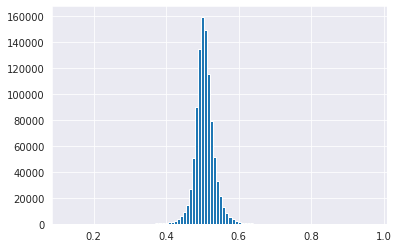

In [25]:
lr_results_df['pred_prob'].hist(bins=100)

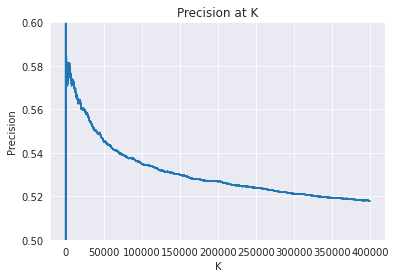

In [29]:
lr_results_df['precision'].head(400000).reset_index(drop=True).plot() # .set_index('pred_prob')
plt.title("Precision at K")
plt.xlabel("K")
plt.ylabel("Precision")
plt.ylim(top=0.6,bottom=0.5);

<AxesSubplot:>

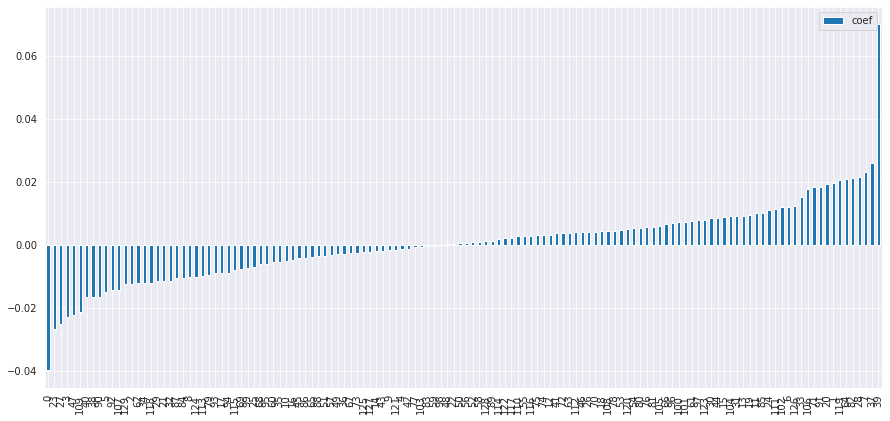

In [39]:
# feature importances
fi = pd.DataFrame(list(zip(all_features, lr_results_dict['estimator']['fold_0'].coef_[0])),columns=['feature','coef'])
fi.sort_values('coef').plot(kind='bar',figsize=(15,7))

In [42]:
%%time
estimator = LGBMClassifier()
rfc_results_dict, rfc_results_df = run_models(estimator=estimator)

<ipython-input-41-8a6f5dd4e7b6>:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fold in tqdm(range(0, df['fold'].nunique()-1, 1)):


Fitting Fold ['train_fold'] Model (1403069 samples) ...
Example Probs:  [0.52237281 0.49953894 0.49978499 0.50195259 0.49169833]
Complete.

Fold ['train_fold'] Train Scores: 
AUC: 0.5957477887376696
Accuracy: 0.558930458872657


Fold fold_0 Test Scores: 
AUC: 0.5187160014941782
Accuracy: 0.51394413370211
Utility Score:  668.524834674919
Utility Score Ideal:  17325.597178819582


Fitting Fold ['train_fold', 'fold_0'] Model (1581316 samples) ...
Example Probs:  [0.48658708 0.50983552 0.5039038  0.50681967 0.49847214]
Complete.

Fold ['train_fold', 'fold_0'] Train Scores: 
AUC: 0.5898824205101257
Accuracy: 0.555283700411556


Fold fold_1 Test Scores: 
AUC: 0.5210537672817278
Accuracy: 0.5149140879520151
Utility Score:  6.216070539761956
Utility Score Ideal:  19621.772493562425


Fitting Fold ['train_fold', 'fold_0', 'fold_1'] Model (1778378 samples) ...
Example Probs:  [0.50380749 0.49812396 0.49339621 0.51522006 0.49341795]
Complete.

Fold ['train_fold', 'fold_0', 'fold_1'] Train Scores:

<AxesSubplot:>

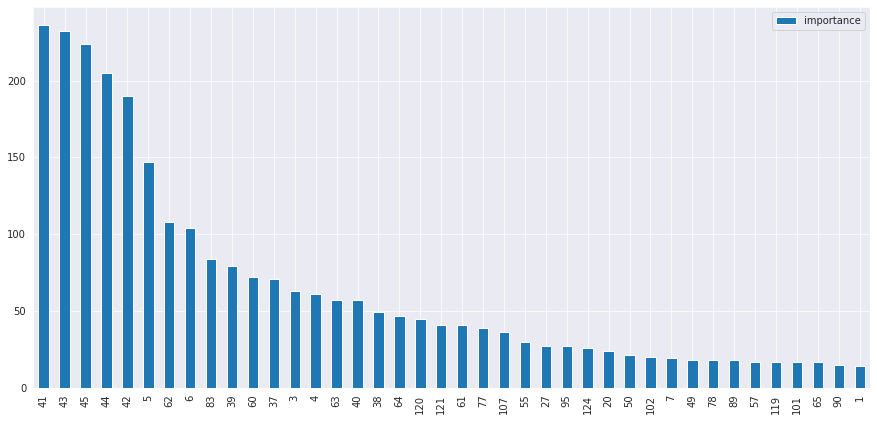

In [49]:
fi = pd.DataFrame(list(zip(all_features, rfc_results_dict['estimator']['fold_2'].feature_importances_)),columns=['feature','importance'])
fi.sort_values('importance', ascending=False)[0:40].plot(kind='bar',figsize=(15,7))